# CIFAR-10 Image Classification Using Convolutional Neural Networks
**Author:** Virginia Herrero

## Introduction

This project explores how to use a Convolutional Neural Network (CNN) to classify images from the CIFAR-10 dataset. CNNs are a type of deep learning model that work especially well with image data because they can automatically learn to detect patterns like edges, shapes, and textures. 

## Goal

The main goal is to build and train a CNN that can accurately classify images from the CIFAR-10 dataset. Along the way, this involves a few key steps: preparing the data, designing the model architecture, training it on the dataset, and evaluating how well it performs. There's also room to experiment with improvements like data augmentation or tuning the model to boost accuracy.

## Dataset Overview

CIFAR-10 is a popular dataset used for training machine learning models on image classification tasks. It contains **60,000 color images**, each just **32x32 pixels**, across **10 different categories**. There are **50,000 images for training** and **10,000 for testing**.

The ten classes are:

* Airplane
* Automobile
* Bird
* Cat
* Deer
* Dog
* Frog
* Horse
* Ship
* Truck

Each image is labeled with one of these classes. While the images are small and simple, they still represent a good challenge for building a working image classifier.

## Import required libraries

As a preliminary step, the necessary libraries are imported. TensorFlow and Keras are used to process image data, build the model and optimize its performance.

In [ ]:
# Data processing
import numpy as np
import pandas as pd
import itertools

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

## Data loading
Load the **CIFAR-10** dataset directly from TensorFlow and split it into training and test sets.

In [ ]:
# Load the dataset
cifar = tf.keras.datasets.cifar10

In [ ]:
# Split the dataset into train and test sets
(x_train, y_train), (x_test, y_test) = cifar.load_data()

In [ ]:
# Print the shape of the training and test
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


Visualize the first 10 images of the training set to have an overview of the images contained in the dataset.

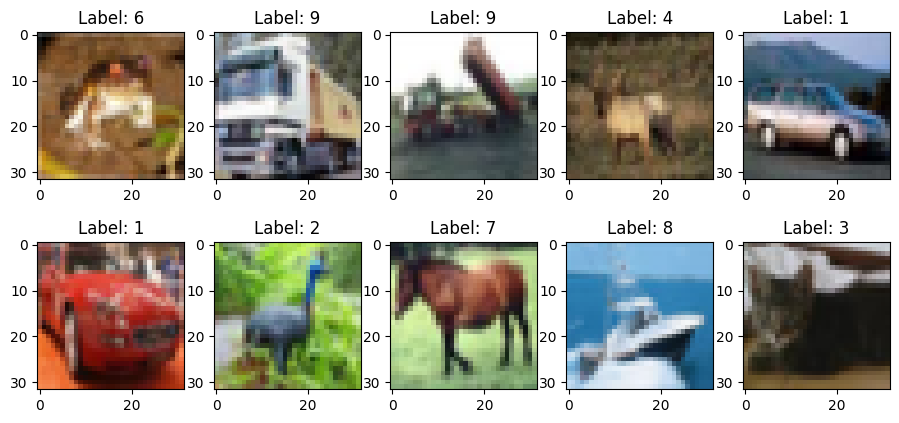

In [ ]:
plt.figure(figsize = (11, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.title(f"Label: {y_train[i][0]}")

## Data exploration

CIFAR-10 is a well-established dataset for learning, so minimal cleaning or preprocessing is required. However, it will be verified that there are no empty or missing images in both the training and test sets, and also the class distribution will be checked.

* **Missing Images**

As expected, the dataset is clean and there are no missing images.

In [ ]:
# Check for NaN values
np.isnan(x_train).any()
np.isnan(x_test).any()

np.False_

* **Class Distribution**

Examine the class distribution within the training set.

In [ ]:
# Define the labels
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Text(0, 0.5, 'Count')

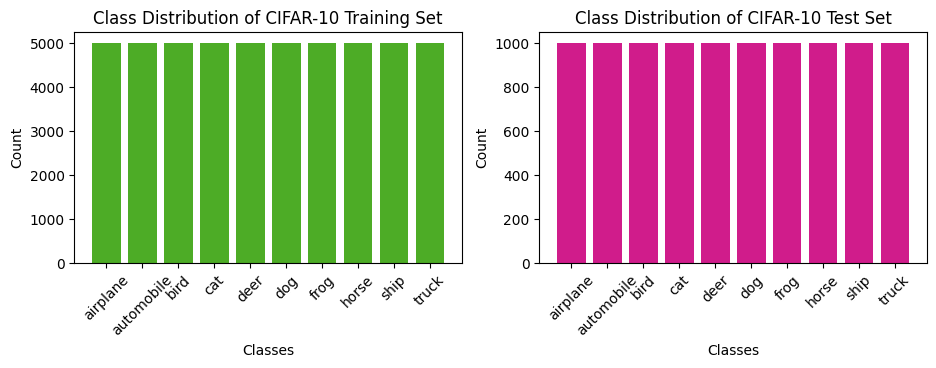

In [ ]:
# Plot class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 3))

# Plot the class distribution for the training set
ax1.hist(y_train, bins = np.arange(11)-0.5, rwidth = 0.8, color = "#4dac26")
ax1.set_xticks(range(10))
ax1.set_xticklabels(classes, rotation = 45)
ax1.set_title("Class Distribution of CIFAR-10 Training Set")
ax1.set_xlabel("Classes")
ax1.set_ylabel("Count")

# Plot the class distribution for the test set
ax2.hist(y_test, bins = np.arange(11)-0.5, rwidth = 0.8, color = "#d01c8b")
ax2.set_xticks(range(10))
ax2.set_xticklabels(classes, rotation = 45)
ax2.set_title("Class Distribution of CIFAR-10 Test Set")
ax2.set_xlabel("Classes")
ax2.set_ylabel("Count")

As anticipated, the dataset is balanced, with each class containing the same number of instances. The training set includes 5.000 instances per class, and the test set contains 1.000 instances per class.

## Pre-processing

Data preprocessing is essential for improving model accuracy, efficiency, and generalization. The preprocessing methods used in this project to prepare the data for the model are: normalization and one-hot encoding.

* **Normalization**

Normalization is a key step in preprocessing, where the pixel values are scaled to an standard range. In this process, the pixel values of both the training and the test images are divided by 255.0, bringing them into a range between 0 and 1. This normalization step ensures the data is in an ideal format for the model, enhancing its ability to learn effectively.

In [ ]:
# Normalize the pixel values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

* **One-hot encoding**

Categorical data can be tricky because machine learning models usually require numerical input, and categorical data doesn't have any inherent numerical relationships. One way to handle this is through one-hot encoding, which converts categorical labels into a binary format, making them easier for models to process. This technique is crucial because it transforms the data into a numerical format that the model can understand and use effectively.

In [ ]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

The final step is to verify the shapes of the data after preprocessing to ensure that everything has been processed correctly.

In [ ]:
print(f"Training data shape after preprocessing: {x_train.shape}")
print(f"Test data shape after preprocessing: {x_test.shape}")
print(f"Training labels shape after one-hot encoding: {y_train.shape}")
print(f"Test labels shape after one-hot encoding: {y_test.shape}")

Training data shape after preprocessing: (50000, 32, 32, 3)
Test data shape after preprocessing: (10000, 32, 32, 3)
Training labels shape after one-hot encoding: (50000, 10)
Test labels shape after one-hot encoding: (10000, 10)
